# CatBoost

In [ ]:
# Import the libraries you'll need
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [74]:
from datetime import datetime
import os

# 現在時刻を取得して、フォーマット
now = datetime.now()
timestamp = now.strftime('%Y%m%d_%H%M%S')

os.makedirs(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}", exist_ok=False)
os.makedirs(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ", exist_ok=False)

<>:8: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
<>:8: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
C:\Users\thisi\AppData\Local\Temp\ipykernel_18636\2640147884.py:8: SyntaxWarning: invalid escape sequence '\W'
  os.makedirs(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}", exist_ok=False)
C:\Users\thisi\AppData\Local\Temp\ipykernel_18636\2640147884.py:9: SyntaxWarning: invalid escape sequence '\W'
  os.makedirs(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ", exist_ok=False)


In [ ]:
# df = pd.read_excel("E:/Je respire/解析/1. 脳血流と問題カテゴリの関連.xlsx", sheet_name="ディアビアイ")
# df = pd.read_excel("/root/workspace/1.2 脳血流と問題カテゴリの関連 - 背外側追加.xlsx", sheet_name="ディアビアイ")
df = pd.read_excel("../1.2 脳血流と問題カテゴリの関連 - 背外側追加.xlsx", sheet_name="ディアビアイ")



In [4]:
df = df.drop(columns=['subject', 'question', #前半部分
                   'dataset_no', 'sheet_name']) # 後半部分

# df = df.iloc[24:246, :]  

In [5]:
df["pupil_std"] = df[["left_pupil_std", "right_pupil_std"]].mean(axis=1, skipna=False)

In [6]:
# 脳血流のオキシヘモグロビンだけ使う場合
df = df.drop(columns=['CH1.1_std', 'CH2.1_std', 'CH3.1_std',
       'CH4.1_std', 'CH5.1_std', 'CH6.1_std', 'CH7.1_std', 'CH8.1_std',
       'CH9.1_std', 'CH10.1_std', 'CH11.1_std', 'CH12.1_std', 'CH13.1_std',
       'CH14.1_std', 'CH15.1_std', 'CH16.1_std', 'CH17.1_std', 'CH18.1_std',
       'CH19.1_std', 'CH20.1_std', 'CH21.1_std', 'CH22.1_std', 'CH1.2_std',
       'CH2.2_std', 'CH3.2_std', 'CH4.2_std', 'CH5.2_std', 'CH6.2_std',
       'CH7.2_std', 'CH8.2_std', 'CH9.2_std', 'CH10.2_std', 'CH11.2_std',
       'CH12.2_std', 'CH13.2_std', 'CH14.2_std', 'CH15.2_std', 'CH16.2_std',
       'CH17.2_std', 'CH18.2_std', 'CH19.2_std', 'CH20.2_std', 'CH21.2_std',
       'CH22.2_std' ]) # 後半部分

df = df.drop(columns=['right_pupil_std','left_pupil_std', 'CH1_std', 'CH2_std',
       'CH3_std', 'CH4_std', 'CH5_std', 'CH6_std', 'CH7_std', 'CH8_std',
       'CH9_std', 'CH10_std', 'CH11_std', 'CH12_std',
       'CH13_std', 'CH14_std', 'CH15_std', 'CH16_std', 'CH17_std',
       'CH18_std', 'CH19_std', 'CH20_std', 'CH21_std',
       'CH22_std']) # 主要な特徴量のみを残す場合


In [7]:
df['score'] = df['score'].replace(2, 1)

In [8]:
df.columns

Index(['q_category', 'score', 'right_haigai', 'hainai', 'left_haigai',
       'Sensor-E:SC/GSR_std', 'Sensor-G:BVP_std', '[G] BVP Amp._std',
       '[G] Heart Rate_std', '[G] HRV Amp._std',
       '[G] HRV-LF Power (0,04-0,16 Hz)_std',
       '[G] HRV-HF Power (0,16-0,4 Hz)_std', '[G] HRV-LF / HRV-HF _std',
       'pupil_std'],
      dtype='object')

In [9]:
df_reading = df[df['q_category']==1]
df_memory = df[df['q_category']==2]
df_recognition = df[df['q_category']==3]
df_attention = df[df['q_category']==4]

In [10]:
df_reading = df_reading.drop(columns=['q_category'])
df_memory = df_memory.drop(columns=['q_category'])
df_recognition = df_recognition.drop(columns=['q_category'])
df_attention = df_attention.drop(columns=['q_category'])

In [11]:
df_reading.shape

(60, 13)

In [12]:
# 使用するdfを指定
df = df_reading

<>:16: SyntaxWarning: invalid escape sequence '\W'
<>:16: SyntaxWarning: invalid escape sequence '\W'
C:\Users\thisi\AppData\Local\Temp\ipykernel_18636\716415434.py:16: SyntaxWarning: invalid escape sequence '\W'
  f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/Correlation Matrix.png",


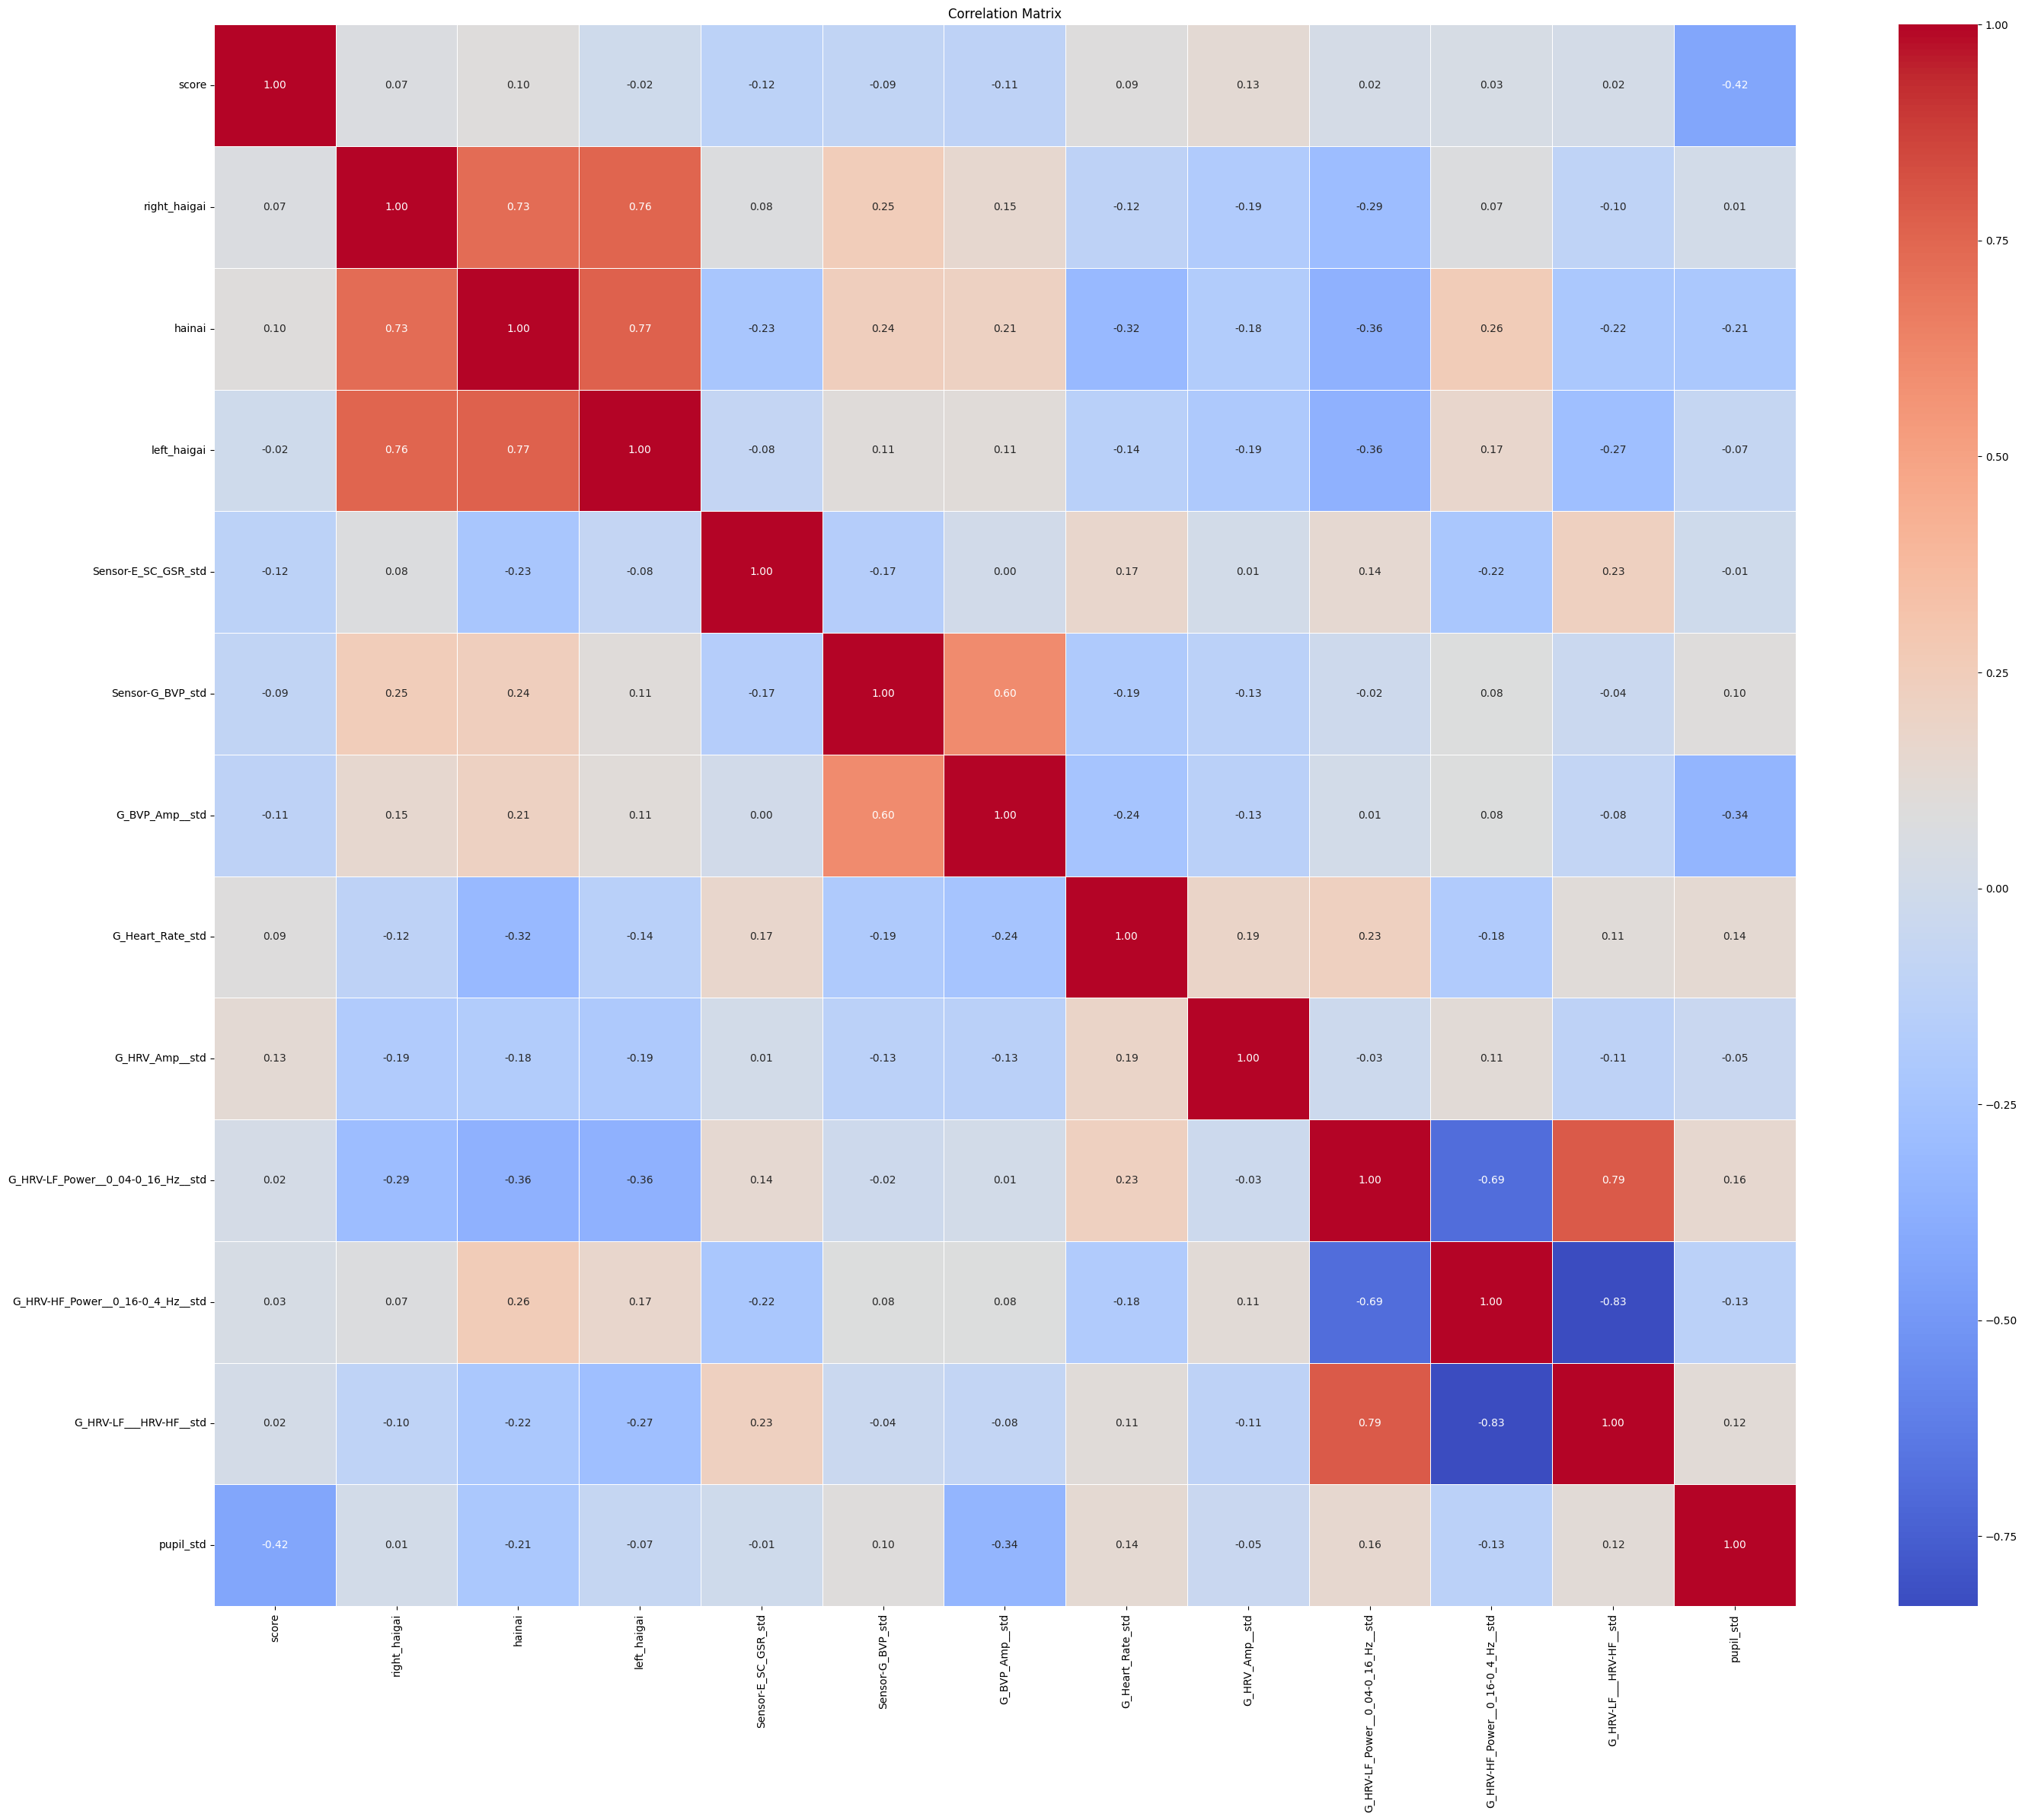

<Figure size 640x480 with 0 Axes>

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 相関行列の計算
corr_matrix = df.corr(method='pearson')

# ヒートマップの描画
plt.figure(figsize=(30, 24))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

plt.savefig(
    f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/Correlation Matrix.png",
    dpi=300,              # 解像度（論文・レポートは300以上推奨）
    bbox_inches='tight',  # 余白を自動調整してカット
    transparent=True      # 背景を透明化
)


In [14]:
df.columns = [col.replace(':', '_')
                .replace('/', '_')
                .replace('[', '')
                .replace(']', '')
                .replace(' ', '_')
                .replace('.', '_')
                .replace(',', '_')
                .replace('(', '_')
                .replace(')', '_')
                for col in df.columns]

In [15]:
X = df.drop(columns=['score'])
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = CatBoostClassifier(random_state=42, verbose=0)
model.fit(X_train, y_train)



In [16]:
# param_dist = {
#     'n_estimators': optuna.distributions.FloatDistribution(50, 500),
#     'max_depth': optuna.distributions.FloatDistribution(2, 50),
#     'min_samples_split': optuna.distributions.FloatDistribution(2, 5),
#     'min_samples_leaf': optuna.distributions.FloatDistribution(2, 10),
#     'max_features': ['sqrt', 'log2']
# }

# Define hyperparameter search space
param_dist = {
    "iterations": optuna.distributions.IntDistribution(200, 1000),
    "depth": optuna.distributions.IntDistribution(3, 10),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.3, log=True),
    "l2_leaf_reg": optuna.distributions.FloatDistribution(1, 10),
    "bagging_temperature": optuna.distributions.FloatDistribution(0, 1),
    "border_count": optuna.distributions.IntDistribution(32, 255),
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

optuna_search = OptunaSearchCV(
    model,
    param_dist,
    cv=cv, # 交差検証の設定
    n_trials=500, # トライアル回数
    scoring='accuracy', # 評価指標
    n_jobs=-1, # 計算するコアの数
    verbose=-1
)

C:\Users\thisi\AppData\Local\Temp\ipykernel_18636\3035061261.py:21: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(


In [ ]:
optuna_search.fit(X_train, y_train) # モデルの学習
y_pred = optuna_search.predict(X_test) # テストデータに対する予測

[I 2025-10-31 13:48:47,928] A new study created in memory with name: no-name-86a46879-f88e-4b52-a3c5-cafadd125128
[I 2025-10-31 13:48:49,609] Trial 2 finished with value: 0.625 and parameters: {'iterations': 444, 'depth': 3, 'learning_rate': 0.058239817248306874, 'l2_leaf_reg': 8.755616211299063, 'bagging_temperature': 0.8016163702598905, 'border_count': 37}. Best is trial 2 with value: 0.625.
[I 2025-10-31 13:48:49,878] Trial 0 finished with value: 0.6458333333333334 and parameters: {'iterations': 497, 'depth': 3, 'learning_rate': 0.013011770123218703, 'l2_leaf_reg': 6.901074959264949, 'bagging_temperature': 0.3187931623078263, 'border_count': 236}. Best is trial 0 with value: 0.6458333333333334.
[I 2025-10-31 13:48:49,910] Trial 14 finished with value: 0.6875 and parameters: {'iterations': 500, 'depth': 3, 'learning_rate': 0.011100280977475266, 'l2_leaf_reg': 8.363393019515172, 'bagging_temperature': 0.7451973479396051, 'border_count': 206}. Best is trial 14 with value: 0.6875.
[I 20

In [ ]:
from joblib import dump
# モデルの保存
dump(optuna_search.best_estimator_, f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/optuna_model.joblib")

In [66]:
print("Best parameters: ", optuna_search.best_params_) # 最良のパラメータの表示
print("Test set accuracy: ", accuracy_score(y_test, y_pred)) # テストデータに対する予測精度の表示
print("Train set accuracy: ", accuracy_score(y_train, optuna_search.predict(X_train))) # 学習データに対する予測精度の表示
print("Test F1 Score: ", f1_score(y_test, y_pred))
print("Train F1 Score: ", f1_score(y_train, optuna_search.predict(X_train)))
print(classification_report(y_test, y_pred, target_names=['Incorrect','Correct'], digits=3, output_dict=True)) # テストデータの分類結果報告

# 結果の保存用の辞書を作成
metrics = {
    "Best Parameters": optuna_search.best_params_,
    "Test Set Accuracy": accuracy_score(y_test, y_pred),
    "Train Set Accuracy": accuracy_score(y_train, optuna_search.predict(X_train)),
    "Test F1 Score": f1_score(y_test, y_pred),
    "Train F1 Score": f1_score(y_train, optuna_search.predict(X_train)),
    "Classification Report": classification_report(y_test, y_pred, target_names=['Incorrect','Correct'], digits=3, output_dict=True)
}

# 保存
pd.DataFrame([metrics]).to_csv(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/metrics.csv", index=False)

# 予測値も保存
pd.DataFrame({"y_true": y_test, "y_pred": y_pred}).to_csv(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/predictions.csv", index=False)

Best parameters:  {'iterations': 500, 'depth': 3, 'learning_rate': 0.011100280977475266, 'l2_leaf_reg': 8.363393019515172, 'bagging_temperature': 0.7451973479396051, 'border_count': 206}
Test set accuracy:  0.8333333333333334
Train set accuracy:  0.9791666666666666
Test F1 Score:  0.9
Train F1 Score:  0.9863013698630136
{'Incorrect': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3.0}, 'Correct': {'precision': 0.8181818181818182, 'recall': 1.0, 'f1-score': 0.9, 'support': 9.0}, 'accuracy': 0.8333333333333334, 'macro avg': {'precision': 0.9090909090909092, 'recall': 0.6666666666666666, 'f1-score': 0.7, 'support': 12.0}, 'weighted avg': {'precision': 0.8636363636363636, 'recall': 0.8333333333333334, 'f1-score': 0.7999999999999999, 'support': 12.0}}


<>:19: SyntaxWarning: invalid escape sequence '\W'
<>:22: SyntaxWarning: invalid escape sequence '\W'
<>:19: SyntaxWarning: invalid escape sequence '\W'
<>:22: SyntaxWarning: invalid escape sequence '\W'
C:\Users\thisi\AppData\Local\Temp\ipykernel_18636\2258375215.py:19: SyntaxWarning: invalid escape sequence '\W'
  pd.DataFrame([metrics]).to_csv(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/metrics.csv", index=False)
C:\Users\thisi\AppData\Local\Temp\ipykernel_18636\2258375215.py:22: SyntaxWarning: invalid escape sequence '\W'
  pd.DataFrame({"y_true": y_test, "y_pred": y_pred}).to_csv(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/predictions.csv", index=False)


<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
C:\Users\thisi\AppData\Local\Temp\ipykernel_18636\2122610726.py:10: SyntaxWarning: invalid escape sequence '\W'
  f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/Confusion Matrix.png",


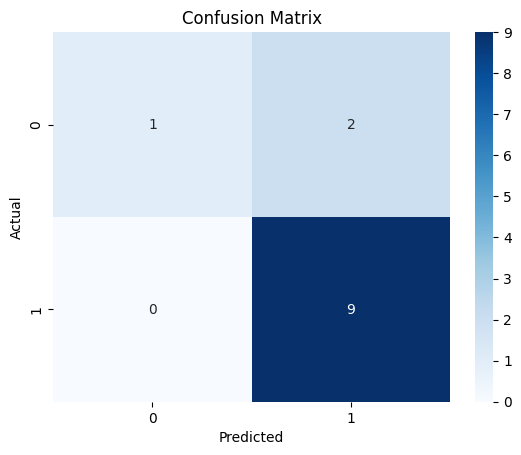

<Figure size 640x480 with 0 Axes>

In [65]:
 # 混同行列の表示
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.savefig(
    f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/Confusion Matrix.png",
    dpi=300,              # 解像度（論文・レポートは300以上推奨）
    bbox_inches='tight',  # 余白を自動調整してカット
    transparent=True      # 背景を透明化
)


In [75]:
explainer = shap.TreeExplainer(model=optuna_search.best_estimator_)
shap_values = explainer.shap_values(X)
explanation = explainer(X)

# SHAPの結果を保存
np.save(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/shap_values.npy", shap_values)
np.save(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/shap_explanation.npy", explanation)
X.to_pickle(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/X.pkl")
X_train.to_pickle(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/X_train.pkl")
X_test.to_pickle(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/X_test.pkl")
y.to_pickle(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/y.pkl")
y_train.to_pickle(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/y_train.pkl")
y_test.to_pickle(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/y_test.pkl")
np.save(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/X.npy", X)
np.save(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/X_train.npy", X_train)
np.save(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/X_test.npy", X_test)
np.save(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/y.npy", X)
np.save(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/y.npy", X)
np.save(f"C:\WorkSpace\Jerespire\結果保存/{timestamp}/データ/y.npy", X)

<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:7: SyntaxWarning: invalid escape sequence '\W'
<>:8: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:11: SyntaxWarning: invalid escape sequence '\W'
<>:12: SyntaxWarning: invalid escape sequence '\W'
<>:13: SyntaxWarning: invalid escape sequence '\W'
<>:14: SyntaxWarning: invalid escape sequence '\W'
<>:15: SyntaxWarning: invalid escape sequence '\W'
<>:16: SyntaxWarning: invalid escape sequence '\W'
<>:17: SyntaxWarning: invalid escape sequence '\W'
<>:18: SyntaxWarning: invalid escape sequence '\W'
<>:19: SyntaxWarning: invalid escape sequence '\W'
<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:7: SyntaxWarning: invalid escape sequence '\W'
<>:8: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:11: SyntaxWarning: invalid escape se

In [36]:
print(explainer)
print(shap_values)
print(explanation)

[[-1.11352411e-01  3.68530808e-02  2.71963473e-03  2.32996428e-01
   1.48030344e-01  1.81515483e-01 -2.85998391e-02 -2.36012637e-02
  -3.53488989e-01  1.47402838e-01  1.82560742e-01  5.39470923e-01]
 [ 5.38054014e-02  1.00432023e-02 -1.66711184e-02  1.99914021e-01
   1.65082939e-01  1.73061447e-01 -4.90452844e-02 -4.05934528e-02
  -3.69285093e-01  1.85285580e-02  2.20652368e-01  7.20785835e-01]
 [-1.35267194e-01 -1.51714292e-02  1.70142380e-02  2.26949464e-01
   1.69569556e-01  1.87378960e-01 -3.31584040e-02 -2.17028251e-02
  -3.66565610e-01  1.06761936e-01  1.89841499e-01  7.26494828e-01]
 [ 5.51256128e-02  2.88046703e-02 -6.45635877e-03  1.95162605e-01
   1.74526038e-01  1.58637477e-01 -7.08514199e-02 -3.13126753e-02
  -3.61640810e-01  1.46212554e-02  2.33708626e-01  5.88262021e-01]
 [ 3.61029277e-02  6.34645428e-03 -3.88029352e-03  1.94305459e-01
   1.72827192e-01  1.58374712e-01 -5.26474017e-02 -2.99811587e-02
  -3.58237505e-01  1.55888146e-02  2.27702847e-01  7.60297458e-01]
 [-1.

In [37]:
shap_values.shape

(60, 12)

In [38]:
shap_values


array([[-1.11352411e-01,  3.68530808e-02,  2.71963473e-03,
         2.32996428e-01,  1.48030344e-01,  1.81515483e-01,
        -2.85998391e-02, -2.36012637e-02, -3.53488989e-01,
         1.47402838e-01,  1.82560742e-01,  5.39470923e-01],
       [ 5.38054014e-02,  1.00432023e-02, -1.66711184e-02,
         1.99914021e-01,  1.65082939e-01,  1.73061447e-01,
        -4.90452844e-02, -4.05934528e-02, -3.69285093e-01,
         1.85285580e-02,  2.20652368e-01,  7.20785835e-01],
       [-1.35267194e-01, -1.51714292e-02,  1.70142380e-02,
         2.26949464e-01,  1.69569556e-01,  1.87378960e-01,
        -3.31584040e-02, -2.17028251e-02, -3.66565610e-01,
         1.06761936e-01,  1.89841499e-01,  7.26494828e-01],
       [ 5.51256128e-02,  2.88046703e-02, -6.45635877e-03,
         1.95162605e-01,  1.74526038e-01,  1.58637477e-01,
        -7.08514199e-02, -3.13126753e-02, -3.61640810e-01,
         1.46212554e-02,  2.33708626e-01,  5.88262021e-01],
       [ 3.61029277e-02,  6.34645428e-03, -3.8802935

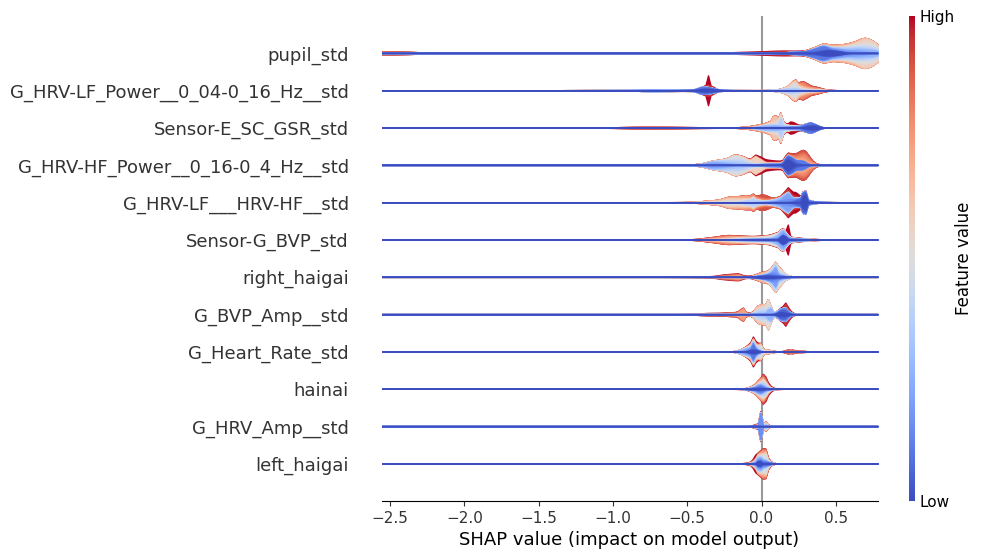

In [39]:
feat_names = list(X.columns)
shap.plots.violin(shap_values, features=X, feature_names=feat_names, plot_type="layered_violin")

In [41]:
print(X.columns)

Index(['right_haigai', 'hainai', 'left_haigai', 'Sensor-E_SC_GSR_std',
       'Sensor-G_BVP_std', 'G_BVP_Amp__std', 'G_Heart_Rate_std',
       'G_HRV_Amp__std', 'G_HRV-LF_Power__0_04-0_16_Hz__std',
       'G_HRV-HF_Power__0_16-0_4_Hz__std', 'G_HRV-LF___HRV-HF__std',
       'pupil_std'],
      dtype='object')


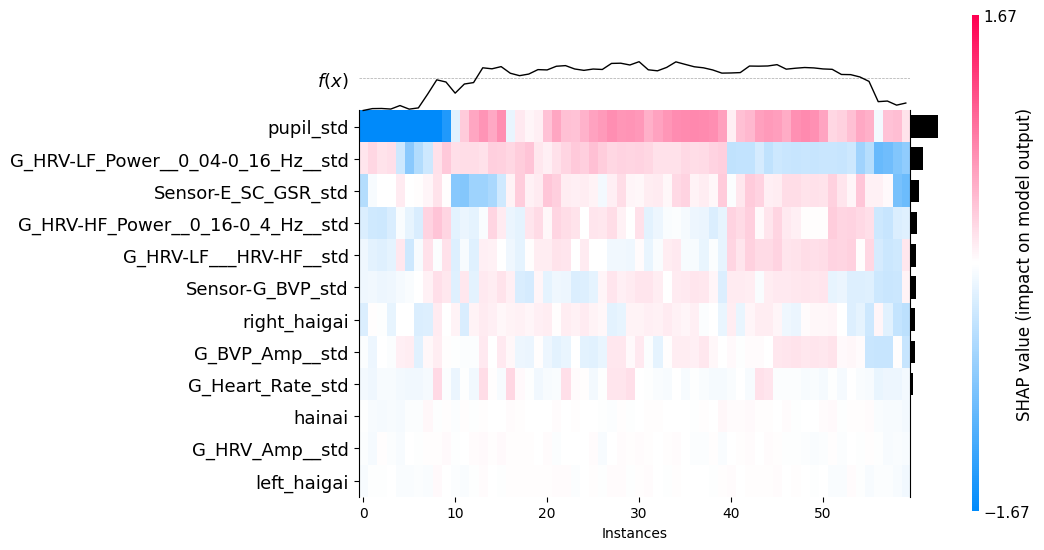

<Axes: xlabel='Instances'>

In [42]:
shap.plots.heatmap(explanation, max_display=12)

Index(['right_haigai', 'hainai', 'left_haigai', 'Sensor-E_SC_GSR_std',
       'Sensor-G_BVP_std', 'G_BVP_Amp__std', 'G_Heart_Rate_std',
       'G_HRV_Amp__std', 'G_HRV-LF_Power__0_04-0_16_Hz__std',
       'G_HRV-HF_Power__0_16-0_4_Hz__std', 'G_HRV-LF___HRV-HF__std',
       'pupil_std'],
      dtype='object')


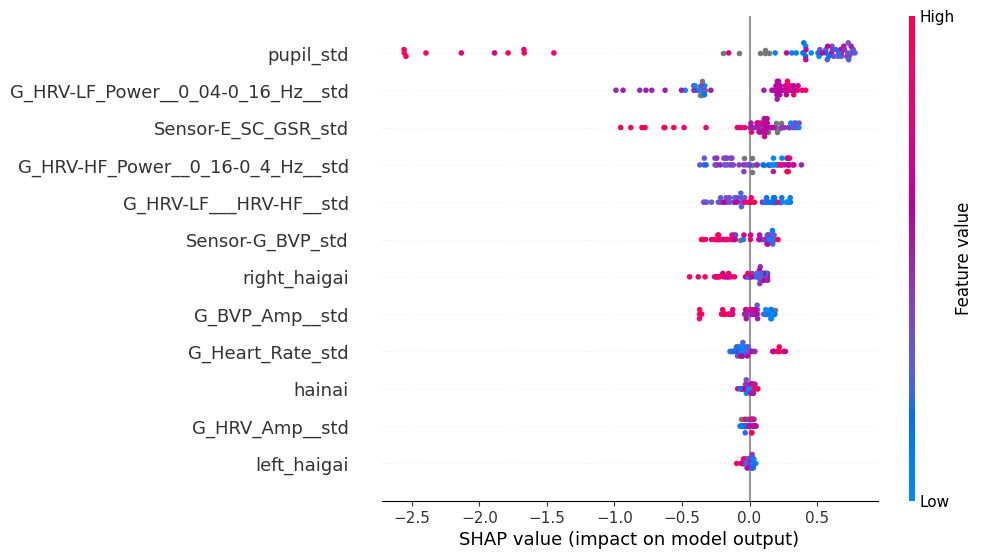

In [43]:
print(X.columns)
shap.plots.beeswarm(explanation, max_display=20)

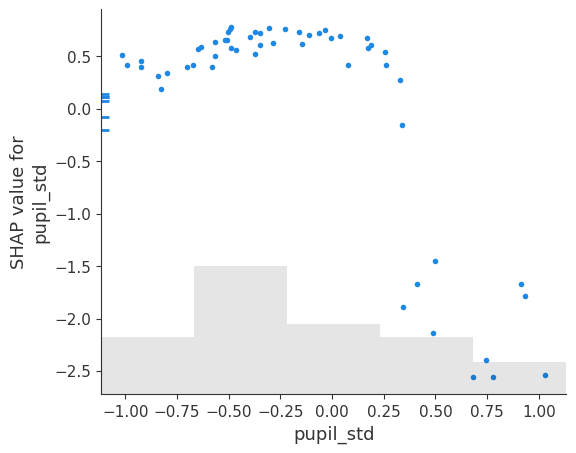

In [44]:
# shap.plots.scatter(explanation[:, "left_pupil_std"], color=explanation[:, "right_pupil_std"])
shap.plots.scatter(explanation[:,11])

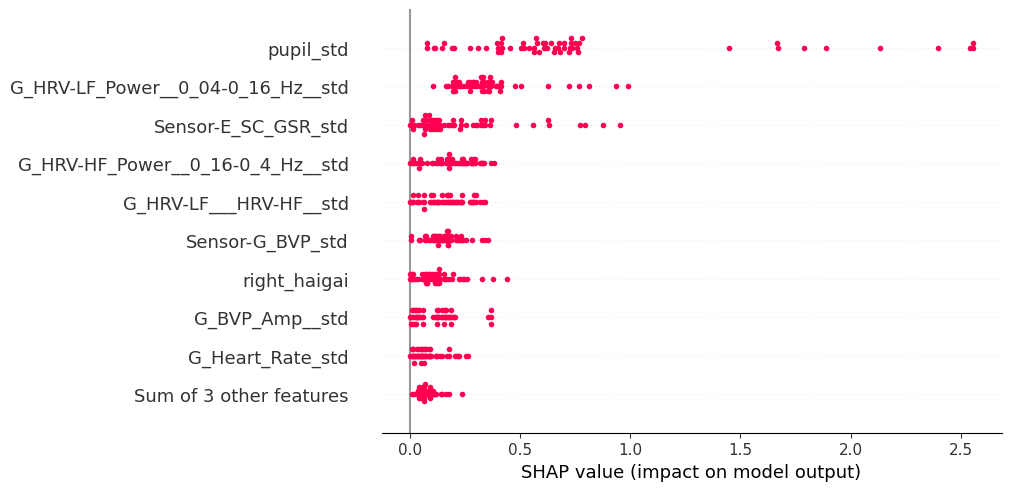

In [45]:
shap.plots.beeswarm(explanation.abs, color="shap_red")

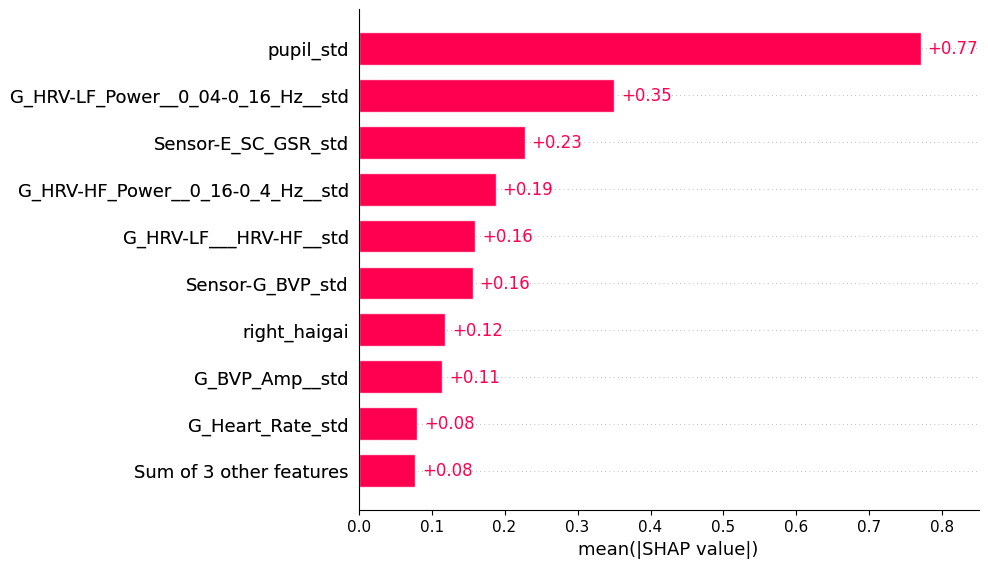

In [46]:
shap.plots.bar(explanation.abs.mean(0))

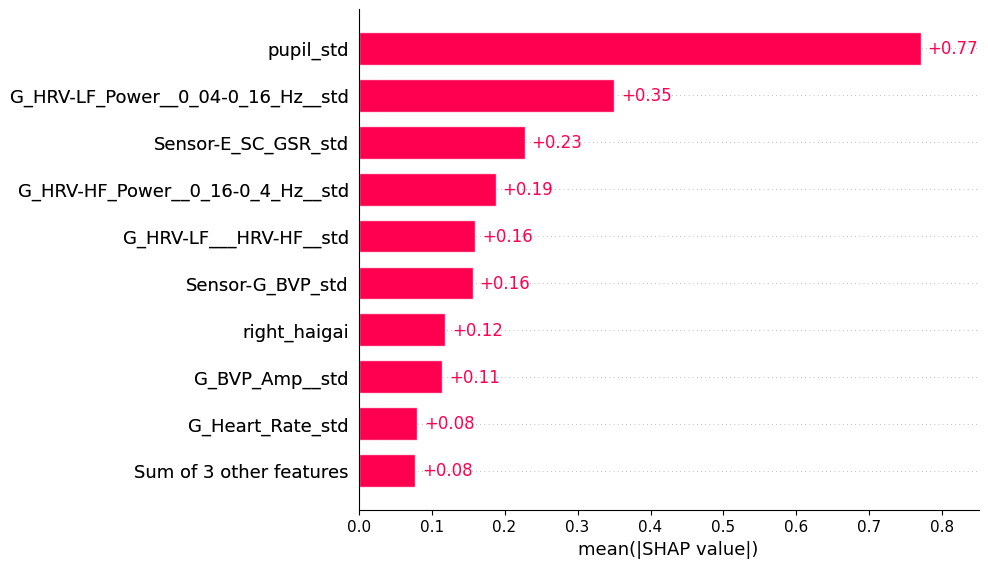

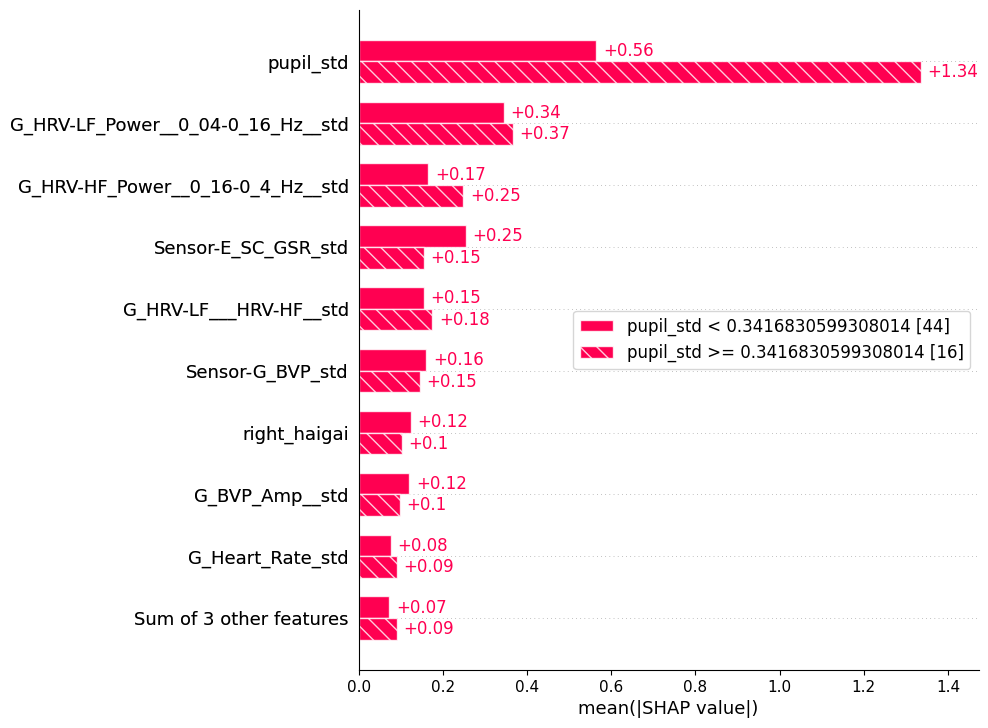

In [47]:
shap.plots.bar(explanation)
shap.plots.bar(explanation.cohorts(2).abs.mean(0))

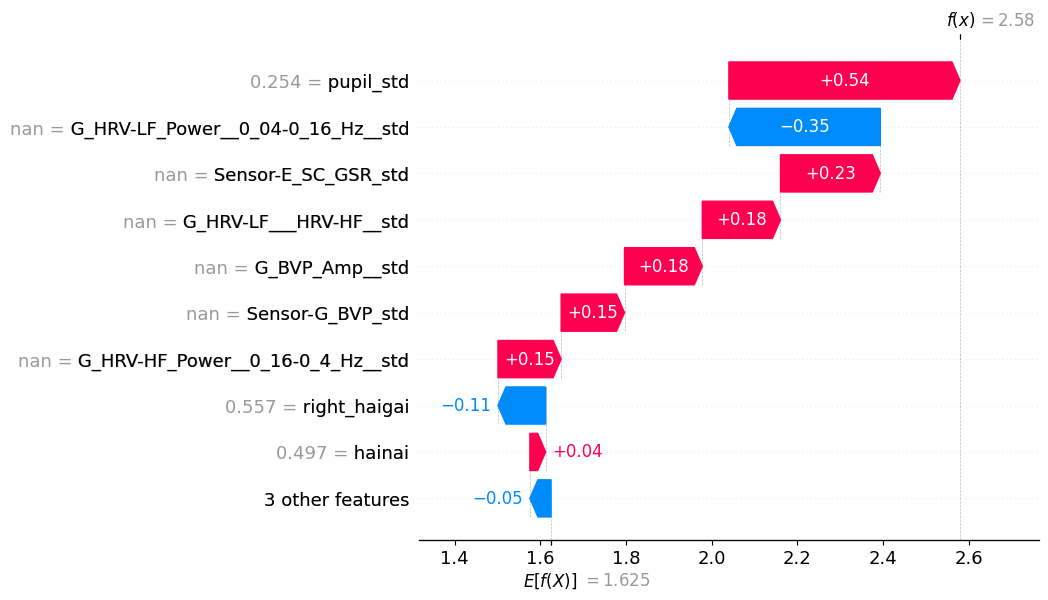

In [48]:
shap.plots.waterfall(explanation[0])